# Clustering for dataset exploration

In this notebook we will discover the underlying groups (or "clusters") in a dataset. We will be clustering companies using their stock market prices, and distinguishing different species by clustering their measurements.

In [1]:
from sklearn.cluster import KMeans
from sklearn import datasets
from sklearn.utils import Bunch
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

import matplotlib.pyplot as plt
from typing import Dict, List
import pandas as pd
import numpy as np
import seaborn as sns
import os

from pandas.core.frame import DataFrame, Series
from numpy.core import ndarray, int32, float64

%matplotlib inline

In [2]:
basedir: str = os.getcwd()

## Section 1. K-means clustering

In this section, we will cluster our samples using k-means clustering. This model finds a specified number of clusters in the samples.

### Subsection 1.1.1: Iris

First, we load the Iris dataset:

In [3]:
iris: Bunch = datasets.load_iris()
iris_features: DataFrame = pd.DataFrame(data=iris['data'], columns=iris.feature_names)
iris_features.head(3)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2


#### Explanatory Data Analysis (EDA)

Above, we can observe that the features of the iris dataset consists of 4 measurements, and therefore this dataset has 4 dimensions:
* Sepal length
* Sepal width
* Petal length
* Petal width

The target variable encodes the species of flower, and there are 3 possibilities as shown below:
* Setosa
* Versicolor
* Virginica

In [4]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

We know from the target names array shown above that
* Setosa corresponds to index `0`
* Versicolor corresponds to index `1`
* Virginica corresponds to index `2`

Thus, we can build this dictionary:

In [5]:
labels_species: Dict[int, str] = dict(zip(range(3), iris.target_names))
labels_species

{0: 'setosa', 1: 'versicolor', 2: 'virginica'}

In [6]:
iris.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename'])

In [7]:
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [8]:
X: ndarray = iris.data
y: ndarray = iris.target

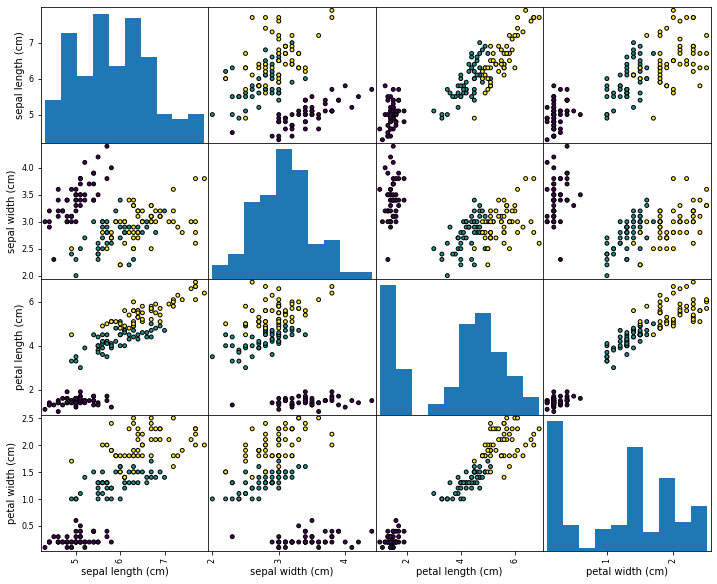

In [9]:
pd.plotting.scatter_matrix(iris_features, figsize=(12, 10), c=(y - 1), alpha=1, edgecolors='k', s=80)
plt.show()

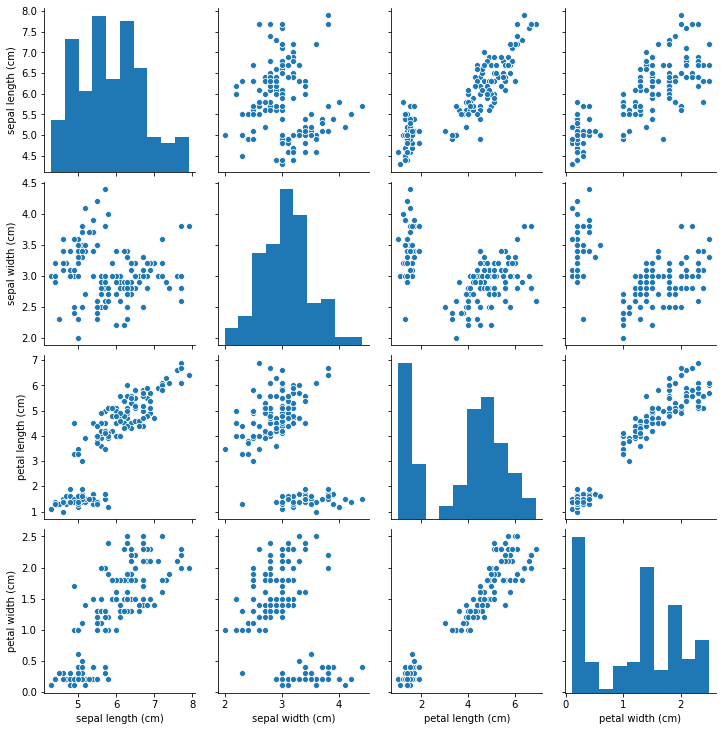

In [10]:
sns.pairplot(iris_features)
plt.show()

Let's specify 3 clusters as there are 3 species of iris. Let's fit the model to the data.

In [11]:
samples: ndarray = iris.data[:-10]
kmeans_model = KMeans(n_clusters=3)
kmeans_model.fit(samples)

KMeans(n_clusters=3)

The fitting is done by locating and memorizing the regions where the different clusters are located.

We can now use the `.predict()` method. This returns a cluster label for each sample, indicating to which cluster a sample belongs.

In [12]:
labels: ndarray = kmeans_model.predict(samples)
labels

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2,
       2, 2, 2, 0, 0, 2, 2, 2, 2, 0, 2, 0, 2, 0, 2, 2, 0, 0, 2, 2, 2, 2,
       2, 0, 2, 2, 2, 2, 0, 2])

k-means remembers the mean of each cluster. These are called the "_centroids_". Therefore, new samples are assigned to the cluster whose centroid is the closest.

In [13]:
new_samples: ndarray = iris.data[-10:]
new_labels = kmeans_model.predict(new_samples)
new_labels

array([2, 2, 0, 2, 2, 2, 0, 2, 2, 0])

In [14]:
sepal_petal_len: DataFrame = iris_features.iloc[:-10, :].filter(regex='length', axis=1)
sepal_petal_len.head(3)

,sepal length (cm),petal length (cm)
0,5.1,1.4
1,4.9,1.4
2,4.7,1.3


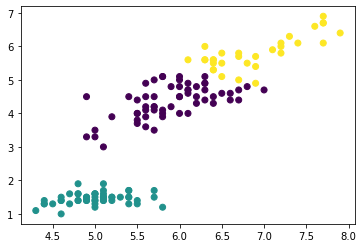

In [15]:
sepal_len: Series = sepal_petal_len.filter(regex='sepal', axis=1)
petal_len: Series = sepal_petal_len.filter(regex='petal', axis=1)

plt.scatter(sepal_len, petal_len, c=labels)
plt.show()

In [16]:
centroids_iris: DataFrame = pd.DataFrame(data=kmeans_model.cluster_centers_, columns=iris.feature_names)
centroids_iris.head(3)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.896610,2.749153,4.359322,1.411864
1,5.006000,3.428000,1.462000,0.246000
2,6.896774,3.054839,5.809677,2.019355


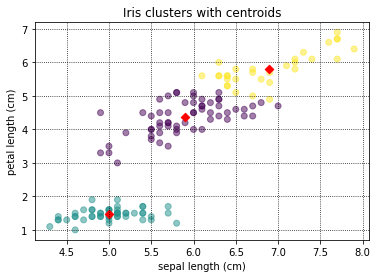

In [17]:
sepal_petal_len_centroids: DataFrame = centroids_iris.filter(regex='length', axis=1)
sepal_len_centroids = sepal_petal_len_centroids.filter(regex='sepal', axis=1)
petal_len_centroids = sepal_petal_len_centroids.filter(regex='petal', axis=1)

plt.scatter(sepal_len, petal_len, c=labels, alpha=0.5)
plt.scatter(sepal_len_centroids, petal_len_centroids, c='r', marker='D')
plt.title('Iris clusters with centroids')
plt.xlabel(sepal_len.columns[0])
plt.ylabel(petal_len.columns[0])
plt.grid(True, c='k', ls=':')
plt.show()

### Subsection 1.1.2 Points

In [18]:
def load_txt(filename: str, basedir: str):
    path: str = os.path.normpath(os.path.join(basedir, filename))
    with open(filename, mode='r') as f:
        for i, line in enumerate(f.readlines()):
            if i == 0:
                data: ndarray = np.array(list(map(float, line.strip('\n').split(', '))))
            else:
                row = np.array(list(map(float, line.strip('\n').split(', '))))
                data = np.vstack((data, row))
    return data

In [19]:
points: ndarray = load_txt('data/points.txt', basedir)
new_points: ndarray = load_txt('data/new_points.txt', basedir)
print(points.shape)

(300, 2)


We are given an array `points` of size 300x2, where each row gives the (x, y) coordinates of a point on a map. We will first make a scatter plot of these points, and use the scatter plot to guess how many clusters there are.

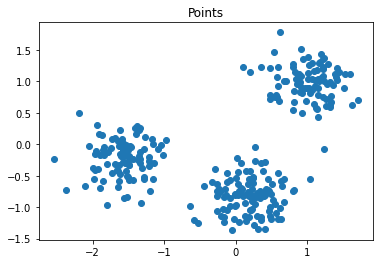

In [20]:
xs: ndarray = points[:, 0]
ys: ndarray = points[:, 1]
plt.scatter(xs, ys)
plt.title('Points')
plt.show()

The scatter plot suggests that there are 3 distinct clusters. We will now create a KMeans model to find 3 clusters, and fit it to the data points. After the model has been fit, we will obtain the cluster labels for some *new points* using the `.predict()` method.

In [21]:
model = KMeans(n_clusters=3)
model.fit(points)
labels = model.predict(new_points)
labels

array([2, 0, 1, 2, 0, 2, 0, 0, 0, 1, 2, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0,
       2, 0, 2, 1, 0, 1, 1, 2, 2, 0, 0, 0, 1, 2, 0, 0, 2, 0, 1, 2, 2, 1,
       2, 0, 1, 1, 0, 0, 0, 0, 1, 1, 2, 2, 1, 1, 1, 2, 2, 0, 0, 0, 2, 0,
       1, 0, 2, 1, 2, 2, 2, 0, 2, 1, 1, 2, 0, 1, 2, 1, 2, 0, 1, 0, 1, 2,
       0, 0, 0, 2, 0, 0, 2, 1, 1, 1, 1, 2, 0, 2, 1, 1, 2, 2, 0, 2, 1, 1,
       2, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 2, 0, 1, 0, 2, 1, 0, 1, 1, 0, 1,
       0, 1, 2, 0, 2, 2, 0, 1, 2, 0, 2, 2, 1, 0, 0, 2, 1, 2, 1, 0, 2, 1,
       1, 2, 1, 0, 0, 1, 0, 1, 1, 0, 0, 2, 0, 0, 1, 2, 1, 2, 2, 0, 2, 0,
       0, 2, 2, 1, 2, 2, 2, 1, 0, 0, 2, 1, 2, 1, 1, 0, 0, 0, 2, 0, 0, 0,
       1, 1, 2, 0, 2, 2, 2, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 0, 0, 2, 1, 2, 2, 1, 2, 1, 2, 1, 0, 0, 1, 0, 0, 0, 1, 2, 2,
       1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 2, 1, 2, 2, 2, 0, 1, 1, 1, 2, 0, 2,
       1, 2, 1, 1, 0, 2, 2, 2, 1, 0, 0, 0, 2, 0, 1, 1, 0, 2, 2, 1, 2, 2,
       1, 2, 0, 2, 1, 1, 1, 1, 0, 1, 1, 0, 0, 2])

We have successfully performed k-Means clustering and predicted the labels of new points. But it is not easy to inspect the clustering by just looking at the printed labels. A visualization would be far more useful.  Below, we will inspect our clustering with a scatter plot!

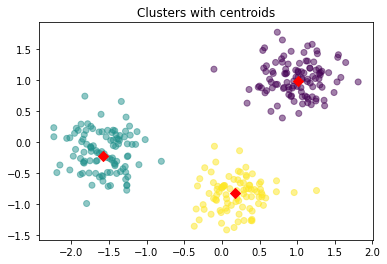

In [22]:
xs: ndarray = new_points[:, 0]
ys: ndarray = new_points[:, 1]

plt.scatter(xs, ys, c=labels, alpha=0.5)

centroids = model.cluster_centers_

centroids_x = centroids[:, 0]
centroids_y = centroids[:, 1]

plt.scatter(centroids_x, centroids_y, marker='D', s=50, c='r')
plt.title('Clusters with centroids')
plt.show()

## Section 2. Evaluating a clustering

We have seen how to use k-means to cluster the iris samples into three clusters. But how can we evaluate the quality of this clustering?

There are 2 approaches.

1. The direct approach is to **compare the clusters with the iris species**. A **drawback** of this approach is that it requires our samples to come pre-grouped into species.
1. **Inertia**: Measure the quality of a clustering that does **not** require our samples to come pre-grouped into species. This method of quality can then be used to make an informed choice about the number of clusters to look for.

### Approach 1

Let's check whether the 3 clusters of iris samples have any correspondence to the iris species. The correspondence can be described by tables usually called *cross-tabulations*.

First, we create this 2-column DataFrame so that each row gives the cluster label and the species of a single sample.

In [23]:
df = pd.DataFrame(data=iris.target, columns=['labels'])
df['species'] = df.labels.apply(lambda x: labels_species[x])
df

,labels,species
0,0,setosa
1,0,setosa
2,0,setosa
3,0,setosa
4,0,setosa
...,...,...
145,2,virginica
146,2,virginica
147,2,virginica
148,2,virginica


The first column contains the cluster labels, and the second column is the iris species.

Next, we can use the `pandas.crosstab` method to build the cross-tabulation:

In [24]:
ct_iris: DataFrame = pd.crosstab(df.labels, df.species)
ct_iris

species,setosa,versicolor,virginica
labels,,,
0,50,0,0
1,0,50,0
2,0,0,50


Cross-tabulations like this provide great insights into which sort of samples are in which cluster.

In [25]:
# df = pd.get_dummies(datasets.load_iris(as_frame=True).target)
# df.columns = iris.target_names
# df.mul(iris.target_names)

### Approach 2: Inertia
In most datasets samples are not labelled by species. So, how can the quality of a clustering be evaluated in these cases?

We need a way to measure the quality of clustering that uses only the clusters and the samples themselves.

A **good clustering** has tight clusters. Therefore, the idea for measuring the quality of clustering can be defined as follows:
* How spread out the samples whithin each cluster can be measured by the **inertia**
* Lower values for this metric is better

Intuitively, **intertia** measures **how far samples are from their centroids**.

The **inertia** of a k-means model is measured automatically when any of the `.fit()` method is called, and is available afterwards as the `.inertia_` attribute.

Here is a plot of the inertia values of clusterings of the iris dataset with different numbers of clusters:

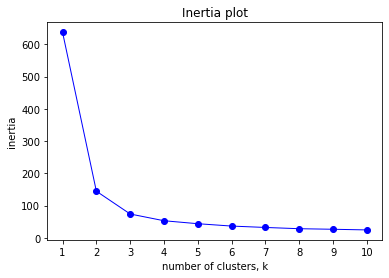

In [26]:
ks = range(1, 11)
inertias: List[float] = []

for k in ks:
    model = KMeans(n_clusters=k)
    
    model.fit(samples)
    
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', c='b', lw=1)
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.title('Inertia plot')
plt.show()

We also notice that inertia decreases slowly as the numbers of clusters increases. The subsequent question that raises is: **What is the best number of clusters?**

This is a trade-off. A good clustering has tight clusters. That is, low inertia. But, a good clustering should also not have too many clusters.

Therefore, a good **rule of thumb** is to choose an **elbow** in the intertia plot.

Hence, conclude from the inertia plot that 3 is a good number of clusters for the iris dataset. 

## Section 3. Transforming features for better clustering

We will now turn on another dataset: the Piedmont wines dataset. Source: [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Wine).

We have a 178 samples of red wine from the Piedmont region of Italy. There are 3 distinct varieties:
* Barolo
* Grignolino
* Barbera

The **features** measure chemical composition (like alcohol content), and visual properties like color intensity.

In [27]:
wine = pd.read_csv(os.path.normpath(os.path.join(basedir, 'data/wine.csv')))
wine

,class_label,class_name,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280,proline
0,1,Barolo,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,Barolo,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,Barolo,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,Barolo,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,Barolo,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,3,Barbera,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740
174,3,Barbera,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750
175,3,Barbera,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835
176,3,Barbera,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840


### Without feature standardization

Let's take the array of samples and use k-means to find 3 clusters.

In [28]:
samples: DataFrame = wine.iloc[:, 2:]
model = KMeans(n_clusters=3, random_state=4)
labels: np.ndarray = model.fit_predict(samples)
labels

array([1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 2, 0, 2, 2, 0,
       2, 2, 0, 0, 0, 2, 2, 1, 0, 2, 2, 2, 0, 2, 2, 0, 0, 2, 2, 2, 2, 2,
       0, 0, 2, 2, 2, 2, 2, 0, 0, 2, 0, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 0,
       2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2,
       2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 2, 2, 0, 0, 2, 0, 0, 2, 2, 2, 2, 0,
       0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0,
       0, 2])

In [29]:
df: DataFrame = pd.DataFrame(data=dict(labels=labels, varieties=wine['class_name']))
ct: DataFrame = pd.crosstab(df['labels'], df['varieties'])
ct

varieties,Barbera,Barolo,Grignolino
labels,,,
0,29,13,20
1,0,46,1
2,19,0,50


This time, the k-means clusters didn't correspond well with the wine varieties.

The problem is that **the features of the wine dataset have very different variances**. As a recall, the variance of a feature measures the spread of its values.

For example, the malic acid feature has a higher variance than the od280 feature. This can be seen from the scatter plot below.

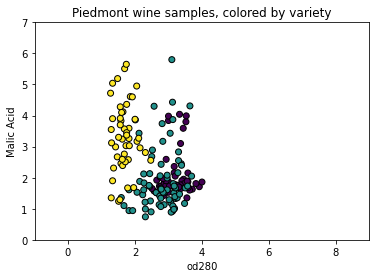

In [30]:
plt.scatter(wine.od280, wine.malic_acid, c=wine['class_label'], edgecolors='k')
plt.ylabel('Malic Acid')
plt.xlabel('od280')
plt.ylim([0, 7])
plt.xlim([-1, 9])
plt.title('Piedmont wine samples, colored by variety')
plt.show()

In [31]:
wine.var()

class_label                 0.600679
alcohol                     0.659062
malic_acid                  1.248015
ash                         0.075265
alcalinity_of_ash          11.152686
magnesium                 203.989335
total_phenols               0.391690
flavanoids                  0.997719
nonflavanoid_phenols        0.015489
proanthocyanins             0.327595
color_intensity             5.374449
hue                         0.052245
od280                       0.504086
proline                 99166.717355
dtype: float64

The differences in some of the feature variances is enormous as seen here, for example, in the scatter plot of the od280 versus proline features!

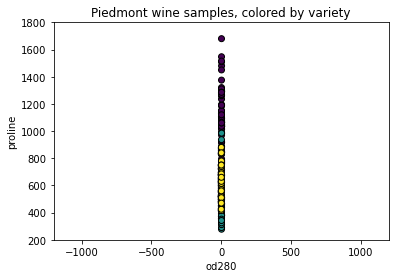

In [32]:
plt.scatter(wine.od280, wine.proline, c=wine.class_label, edgecolors='k')
plt.ylabel('proline')
plt.ylim([200, 1800])
plt.xlabel('od280')
plt.xlim([-1200, 1200])
plt.title('Piedmont wine samples, colored by variety')
plt.show()

In k-means clustering, **the variance of a feature corresponds to its influence on the clustering algorithm**. In short: $\text{feature variance} = \text{feature influence}$.

### With feature standardization

To give every feature a chance, the data needs to be transformed so that features have **equal variance**. This can be achieved with the `StandardScaler` from scikit-learn which transforms each feature to have mean 0 and variance 1.

Eventually, the resulting "standardized" features can be very informative.

Using standardized od280 and proline, for instance, the 3 wine varieties are much more distinct.

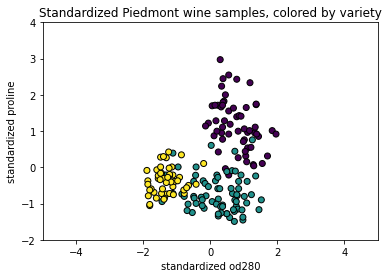

In [33]:
scaler = StandardScaler()
scaler.fit(samples)
standardized_wine = pd.DataFrame(data=scaler.transform(samples), columns=samples.columns)

plt.scatter(standardized_wine.od280, standardized_wine.proline, c=wine['class_label'], edgecolors='k')
plt.ylabel('standardized proline')
plt.ylim([-2, 4])
plt.xlabel('standardized od280')
plt.xlim([-5, 5])
plt.title('Standardized Piedmont wine samples, colored by variety')
plt.show()

In [34]:
# Standardize features with a pipeline
scaler = StandardScaler()
kmeans = KMeans(n_clusters=3, random_state=21)
pipeline = make_pipeline(scaler, kmeans)
labels: np.ndarray = pipeline.fit_predict(samples)
    
# Cross-tabulation
df: DataFrame = pd.DataFrame(data=dict(labels=labels, varieties=wine['class_name']))
ct: DataFrame = pd.crosstab(df['labels'], df['varieties'])
ct

varieties,Barbera,Barolo,Grignolino
labels,,,
0,0,59,3
1,48,0,3
2,0,0,65


Checking the correspondence between the cluster labels and the wine varieties reveals that this new clustering, incorporating standardization, is fantastic! Its 3 clusters correspond almost exactly to the 3 wine varieties. This is a huge improvement on the clustering without standardization.